In [1]:
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms
from torchsummary import summary

# Подготовка тренировочного датасета

In [2]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 2060
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [3]:
device

device(type='cuda')

In [4]:
pd.read_csv('../data/train_answers.csv').head()

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6


In [5]:
categories = pd.read_csv('../data/activity_categories.csv')

categories.head()

,id,category
0,0,sports
1,1,inactivity quiet/light
2,2,miscellaneous
3,3,occupation
4,4,water activities


In [6]:
id_to_category = dict(zip(categories['id'], categories['category']))

In [7]:
class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, csv_file, transform=None):
        """
        img_dir: Папка с изображениями (В моем случае, 'drive/MyDrive/DataSets/human_poses_data/img_train').
        csv_file: Путь к таблице с метками (например, 'train_answers.csv').
        transform: Трансформации для предобработки изображений.
        """
        self.img_dir = img_dir
        self.labels = pd.read_csv(csv_file)  # Загружаем таблицу меток
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        # Достаем имя изображения и метку
        img_id = self.labels.iloc[idx, 0]  # img_id (имя изображения)
        label = self.labels.iloc[idx, 1]  # target_feature (метка)

        # Загружаем изображение
        img_path = os.path.join(self.img_dir, str(img_id)+'.jpg')
        image = Image.open(img_path).convert("RGB")  # Убедимся, что изображение в RGB

        # Применяем трансформации
        if self.transform:
            image = self.transform(image)

        return image, label


In [8]:
transform = transforms.Compose([
    transforms.Resize((227, 227)),  # Изменяем размер изображений
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [9]:
RANDOM_SEED = 52
generator = torch.Generator().manual_seed(RANDOM_SEED)

In [14]:
print(f"Available CPU cores: {os.cpu_count()}")

Available CPU cores: 8


In [11]:
dataset = HumanPoseDataset(
    img_dir='../data/img_train',
    csv_file='../data/train_answers.csv',
    transform=transform
)

train_dataset, val_dataset = random_split(dataset, [int(0.9*len(dataset)), len(dataset) - int(0.9*len(dataset))], generator)

In [15]:
# Функция для отображения изображений с подписями
def show_images_with_labels(dataset, id_to_category, num_images=10):
    fig, axes = plt.subplots(1, num_images, figsize=(20, 5))
    for i in range(num_images):
        # Достаем изображение и метку
        image, label = dataset[i]
        # img_name = dataset.labels.iloc[i, 0]  # Имя файла

        # Декодируем метку в категорию
        category = id_to_category[label] if id_to_category else label

        # # Отображаем изображение
        axes[i].imshow(image.permute(1, 2, 0))  # Преобразуем тензор в (H, W, C)

In [16]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.6051416].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.2102921..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0357141..2.4134207].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input

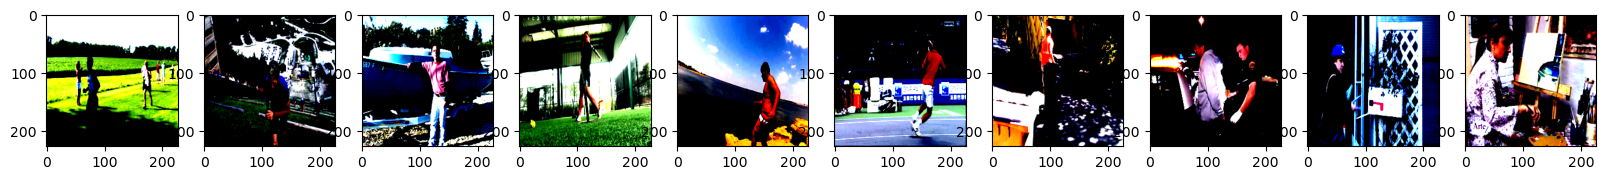

In [17]:
# Получить батч данных
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Вывести первые 5 изображений в одну строку
show_images_with_labels(train_dataset, id_to_category)

# Архитектуры

In [15]:
class AlexNetArtem(nn.Module):
    def __init__(self, num_classes):
        super(AlexNetArtem, self).__init__()
        self.num_classes = num_classes
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=96, kernel_size=11, stride=4, padding=0
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(
                in_channels=96, out_channels=256, kernel_size=5, padding=2
            ),
            nn.ReLU(),
            nn.LocalResponseNorm(
                alpha=1e-4, beta=0.75, k=2, size=5
            ),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.conv_block_3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_4 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=384, kernel_size=3, padding=1
            ),
            nn.ReLU(),
        )
        self.conv_block_5 = nn.Sequential(
            nn.Conv2d(
                in_channels=384, out_channels=256, kernel_size=3, padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )

        self.classifier = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=256 * 6 * 6, out_features=4096),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),
            nn.Linear(
                in_features=4096, out_features=self.num_classes
            ),
        )
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.conv_block_3(x)
        x = self.conv_block_4(x)
        x = self.conv_block_5(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [18]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=1000):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),

            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),

            nn.Linear(4096, num_classes),
        )

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [19]:
len(id_to_category)

20

In [20]:
summary(AlexNet(20).to(device), (3, 227, 227))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]          23,296
              ReLU-2           [-1, 64, 56, 56]               0
         MaxPool2d-3           [-1, 64, 27, 27]               0
            Conv2d-4          [-1, 192, 27, 27]         307,392
              ReLU-5          [-1, 192, 27, 27]               0
         MaxPool2d-6          [-1, 192, 13, 13]               0
            Conv2d-7          [-1, 384, 13, 13]         663,936
              ReLU-8          [-1, 384, 13, 13]               0
            Conv2d-9          [-1, 256, 13, 13]         884,992
             ReLU-10          [-1, 256, 13, 13]               0
           Conv2d-11          [-1, 256, 13, 13]         590,080
             ReLU-12          [-1, 256, 13, 13]               0
        MaxPool2d-13            [-1, 256, 6, 6]               0
          Dropout-14                 [-

# Обучение

In [21]:
from torch.optim import Adam
from torch.utils.data import DataLoader
from ignite.engine import Engine, Events
from ignite.handlers import Checkpoint, DiskSaver, global_step_from_engine
from ignite.metrics import Accuracy, Loss
from ignite.contrib.handlers import ProgressBar
import logging
import tqdm

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/checkpoint.py:16: DeprecationWarning: `TorchScript` support for functional optimizers is deprecated and will be removed in a future PyTorch release. Consider using the `torch.compile` optimizer instead.
  from torch.distributed.optim import ZeroRedundancyOptimizer


In [22]:
model = AlexNet(20).to(device)

In [24]:
# Определение функции потерь и оптимизатора
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

# Создание DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

In [25]:
import time

time.localtime()

time.struct_time(tm_year=2024, tm_mon=12, tm_mday=7, tm_hour=15, tm_min=41, tm_sec=55, tm_wday=5, tm_yday=342, tm_isdst=0)

In [26]:
# Определяем одну итерацию обучения (тренировочный шаг)
def train_step(engine, batch):
    model.train()  # Переводим модель в режим обучения
    images, labels = batch
    images, labels = images.to(device), labels.to(device)  # Перенос данных на устройство (CPU/GPU)
    optimizer.zero_grad()  # Обнуляем градиенты
    outputs = model(images)  # Прямой проход (forward pass)
    loss = criterion(outputs, labels)  # Вычисляем функцию потерь
    loss.backward()  # Вычисляем градиенты
    optimizer.step()  # Обновляем параметры модели
    # Возвращаем результаты: значение функции потерь, выходы модели и метки
    return {"loss": loss.item(), "outputs": outputs, "labels": labels}

# Определяем одну итерацию валидации
def val_step(engine, batch):
    model.eval()  # Переводим модель в режим оценки
    with torch.no_grad():  # Отключаем вычисление градиентов (ускоряет выполнение и экономит память)
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)  # Прямой проход
        return outputs, labels  # Возвращаем предсказания и истинные метки

# Создаём движки (engines) для тренировки и валидации
trainer = Engine(train_step)  # Движок для обучения
evaluator = Engine(val_step)  # Движок для валидации

# Добавляем метрики для обучения
train_loss = Loss(criterion, output_transform=lambda x: (x["outputs"], x["labels"]))
train_accuracy = Accuracy(output_transform=lambda x: (x["outputs"], x["labels"]))
train_loss.attach(trainer, "loss")  # Привязываем метрику функции потерь к тренеру
train_accuracy.attach(trainer, "accuracy")  # Привязываем метрику точности к тренеру

# Добавляем метрики для валидации
Accuracy().attach(evaluator, "accuracy")  # Точность
Loss(criterion).attach(evaluator, "loss")  # Функция потерь

# Прогресс-бар для отображения статуса обучения
ProgressBar().attach(trainer)
ProgressBar().attach(evaluator)

cur_time = time.localtime()
path_suf = '_' + str(cur_time.tm_mday) + '_' + str(cur_time.tm_mon) + '_' + str(cur_time.tm_hour) + '_' + str(cur_time.tm_min)

# Настройка логирования
log_dir = "./train_info/logs" + path_suf
os.makedirs(log_dir, exist_ok=True)  # Создаём директорию для логов, если её нет
logging.basicConfig(
    filename="training.log",  # Файл для записи логов
    level=logging.INFO,  # Уровень логирования
    format="%(asctime)s - %(message)s",  # Формат записей
)
logger = logging.getLogger()  # Создаём логгер

# Создаём DataFrame для метрик
metrics_path = os.path.join(log_dir, "metrics.csv")
if os.path.exists(metrics_path):
    # Если файл уже существует, загружаем его (например, для продолжения тренировки)
    metrics_df = pd.read_csv(metrics_path)
else:
    # Создаём новый DataFrame, если файла ещё нет
    metrics_df = pd.DataFrame(columns=["Epoch", "Train Loss", "Train Accuracy", "Validation Loss", "Validation Accuracy"])

# Настраиваем сохранение модели при лучших результатах
to_save = {"model": model, "optimizer": optimizer, "trainer": trainer}
handler = Checkpoint(
    to_save,  # Что сохранять
    DiskSaver("./train_info/checkpoints" + path_suf, create_dir=True, require_empty=False, atomic=False),  # Диск-сохранитель
    n_saved=3,  # Сохранять только последние 3 чекпоинта
    filename_prefix="best",  # Префикс имени файла
    score_function=lambda engine: engine.state.metrics["accuracy"],  # Критерий выбора "лучшей" модели
    score_name="val_accuracy",  # Название критерия
    global_step_transform=global_step_from_engine(trainer),  # Глобальный шаг (номер итерации)
)

# Добавляем событие для логирования и сохранения метрик после каждой эпохи
@trainer.on(Events.EPOCH_COMPLETED)
def log_and_save_metrics(engine):
    # Получаем метрики для тренировки
    train_metrics = engine.state.metrics
    train_loss = train_metrics["loss"]
    train_accuracy = train_metrics["accuracy"]
    
    # Запускаем валидацию
    evaluator.run(val_loader)
    val_metrics = evaluator.state.metrics
    val_loss = val_metrics["loss"]
    val_accuracy = val_metrics["accuracy"]
    
    # Логируем метрики
    logger.info(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
                f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"Epoch {engine.state.epoch}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, "
          f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Сохраняем метрики в DataFrame и записываем в CSV
    global metrics_df
    metrics_df = pd.concat(
        [metrics_df, pd.DataFrame({
            "Epoch": [engine.state.epoch],
            "Train Loss": [train_loss],
            "Train Accuracy": [train_accuracy],
            "Validation Loss": [val_loss],
            "Validation Accuracy": [val_accuracy],
        })],
        ignore_index=True
    )
    metrics_df.to_csv(metrics_path, index=False)  # Сохраняем таблицу в CSV
    
    # Сохраняем модель
    handler(evaluator)

/home/bottic/anaconda3/envs/ttorchenv/lib/python3.10/site-packages/ignite/handlers/tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [27]:
trainer.run(train_loader, max_epochs=25)

# Полный output обучения можно посмотреть в traning.log

/tmp/ipykernel_48272/2703107813.py:97: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  metrics_df = pd.concat(


Epoch 1: Train Loss: 2.6313, Train Accuracy: 0.1971, Validation Loss: 2.4770, Validation Accuracy: 0.2336


Epoch 2: Train Loss: 2.4891, Train Accuracy: 0.2201, Validation Loss: 2.4199, Validation Accuracy: 0.2433


Epoch 3: Train Loss: 2.4075, Train Accuracy: 0.2471, Validation Loss: 2.3313, Validation Accuracy: 0.2579


Epoch 4: Train Loss: 2.3380, Train Accuracy: 0.2707, Validation Loss: 2.2854, Validation Accuracy: 0.2789


Epoch 5: Train Loss: 2.2661, Train Accuracy: 0.2790, Validation Loss: 2.2368, Validation Accuracy: 0.2951


Epoch 6: Train Loss: 2.2146, Train Accuracy: 0.2951, Validation Loss: 2.2399, Validation Accuracy: 0.2910


Epoch 7: Train Loss: 2.1630, Train Accuracy: 0.3116, Validation Loss: 2.2019, Validation Accuracy: 0.3137


Epoch 8: Train Loss: 2.1005, Train Accuracy: 0.3366, Validation Loss: 2.1475, Validation Accuracy: 0.3258


Epoch 9: Train Loss: 2.0213, Train Accuracy: 0.3656, Validation Loss: 2.0748, Validation Accuracy: 0.3597


Epoch 10: Train Loss: 1.9196, Train Accuracy: 0.3906, Validation Loss: 2.0629, Validation Accuracy: 0.3727


Epoch 11: Train Loss: 1.8086, Train Accuracy: 0.4263, Validation Loss: 2.0009, Validation Accuracy: 0.3880


Epoch 12: Train Loss: 1.6992, Train Accuracy: 0.4546, Validation Loss: 1.9549, Validation Accuracy: 0.4139


Epoch 13: Train Loss: 1.5884, Train Accuracy: 0.4972, Validation Loss: 1.9649, Validation Accuracy: 0.4139


Epoch 14: Train Loss: 1.4496, Train Accuracy: 0.5352, Validation Loss: 1.9247, Validation Accuracy: 0.4317


Epoch 15: Train Loss: 1.3482, Train Accuracy: 0.5686, Validation Loss: 1.8780, Validation Accuracy: 0.4301


Epoch 16: Train Loss: 1.1967, Train Accuracy: 0.6103, Validation Loss: 1.9265, Validation Accuracy: 0.4446


Epoch 17: Train Loss: 1.0857, Train Accuracy: 0.6521, Validation Loss: 1.9518, Validation Accuracy: 0.4252


Epoch 18: Train Loss: 0.9627, Train Accuracy: 0.6863, Validation Loss: 1.9377, Validation Accuracy: 0.4737


Epoch 19: Train Loss: 0.9207, Train Accuracy: 0.7077, Validation Loss: 1.9673, Validation Accuracy: 0.4527


Epoch 20: Train Loss: 0.8233, Train Accuracy: 0.7338, Validation Loss: 1.9556, Validation Accuracy: 0.4527


Epoch 21: Train Loss: 0.7374, Train Accuracy: 0.7616, Validation Loss: 1.9743, Validation Accuracy: 0.4665


Epoch 22: Train Loss: 0.6507, Train Accuracy: 0.7900, Validation Loss: 2.0471, Validation Accuracy: 0.4592


Epoch 23: Train Loss: 0.6115, Train Accuracy: 0.8035, Validation Loss: 2.0843, Validation Accuracy: 0.4576


Epoch 24: Train Loss: 0.5568, Train Accuracy: 0.8220, Validation Loss: 2.0592, Validation Accuracy: 0.4592


Epoch 25: Train Loss: 0.4871, Train Accuracy: 0.8446, Validation Loss: 2.2365, Validation Accuracy: 0.4576


State:
	iteration: 4350
	epoch: 25
	epoch_length: 174
	max_epochs: 25
	output: <class 'dict'>
	batch: <class 'list'>
	metrics: <class 'dict'>
	dataloader: <class 'torch.utils.data.dataloader.DataLoader'>
	seed: <class 'NoneType'>
	times: <class 'dict'>

# Просмотр результатов обучения

Перед просмотром результатов обучения, убедитесь, что запускали ячеки из папок 'Подготовка тренировочного датасета' и 'Архитектуры'

In [30]:
import pandas as pd
from torch.optim import Adam
from ignite.contrib.handlers import ProgressBar
from ignite.engine import Engine

In [ ]:
# train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0)
# val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=3)

<Axes: >

<Figure size 640x480 with 0 Axes>

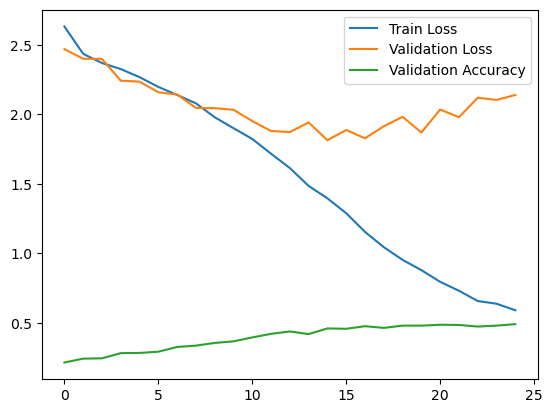

In [32]:
metrics_path = "./train_info/logs_7_12_14_5/metrics.csv"

metrics = pd.read_csv(metrics_path)

plt.figure()
metrics[['Train Loss', 'Validation Loss', 'Validation Accuracy']].plot()

In [22]:
from ignite.handlers import Checkpoint
import torch

In [23]:
print("CUDA available:", torch.cuda.is_available())
print("CUDA device name:", torch.cuda.get_device_name(0))
print("PyTorch CUDA version:", torch.version.cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
x = torch.rand(3, 3).to(device)
print("Tensor device:", x.device)

CUDA available: True
CUDA device name: NVIDIA GeForce RTX 4070 SUPER
PyTorch CUDA version: 12.4
Tensor device: cuda:0


In [24]:
model = AlexNet(20).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

In [25]:
checkpoint_path = "./train_info/checkpoints_5_12_20_59/best_checkpoint_95_val_accuracy=0.5004.pt"

checkpoint = torch.load(checkpoint_path)

model.load_state_dict(checkpoint["model"])
optimizer.load_state_dict(checkpoint["optimizer"])

model.eval()

start_epoch = checkpoint["trainer"]['iteration'] / checkpoint["trainer"]['epoch_length']
start_epoch

C:\Users\Vlad\AppData\Local\Temp\ipykernel_8468\910594076.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


95.0

In [26]:
checkpoint['trainer']

OrderedDict([('epoch_length', 174), ('max_epochs', 100), ('iteration', 16530)])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.64].


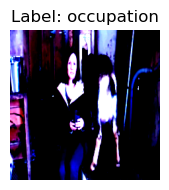

occupation


In [27]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


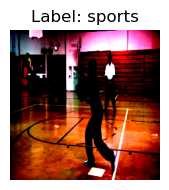

sports


In [30]:
dataiter = iter(DataLoader(val_dataset, batch_size=64, shuffle=True, num_workers=0))
images, labels = next(dataiter)

show_images_row([images[0]], [label.item() for label in labels[:5]], size=(2, 2))

probabilities = torch.softmax(model(images[0].unsqueeze(0).to(device)), dim=1)
predicted_class = torch.argmax(probabilities, dim=1).item()

print(id_to_category[predicted_class])

In [29]:
from ignite.metrics import Accuracy
from ignite.metrics import Precision, Recall, Fbeta, Accuracy

# Функция инференса для вычисления метрик
def inference_step(engine, batch):
    model.eval()
    with torch.no_grad():
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        return outputs, labels

# Создаём Engine для инференса
evaluator = Engine(inference_step)

# Добавляем метрику Accuracy
accuracy = Accuracy()
precision = Precision(average=True)
recall = Recall(average=True)
f1 = Fbeta(beta=1.0, average=True)

accuracy.attach(evaluator, "accuracy")
precision.attach(evaluator, "precision")
recall.attach(evaluator, "recall")
f1.attach(evaluator, "f1")

pbar = ProgressBar(persist=True)
pbar.attach(evaluator)

# Оценка на валидационном датасете
state = evaluator.run(val_loader)

print(f"Validation Accuracy: {state.metrics['accuracy']:.4f}")
print(f"Validation Precision: {state.metrics['precision']:.4f}")
print(f"Validation Recall: {state.metrics['recall']:.4f}")
print(f"Validation F1 Score: {state.metrics['f1']:.4f}")

c:\Users\Vlad\.conda\envs\DL_ENV\lib\site-packages\ignite\handlers\tqdm_logger.py:127: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
Iteration: [20/20] 100%|██████████ [00:16<00:00]

Validation Accuracy: 0.5004
Validation Precision: 0.3904
Validation Recall: 0.3489
Validation F1 Score: 0.3578
